# Ficha nr2 - CNN RGB cifar


**Ruben Silva** - pg57900


### Tarefa 1,2,3

T1 -> Já tenho no Computador

In [1]:
# Core Libraries
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# PyTorch Core
import torch
from torch.serialization import safe_globals
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import (
    Conv2d, MaxPool2d, ReLU, Softmax, Linear, Sequential, Module,
    BatchNorm2d, Dropout2d, CrossEntropyLoss
)
from torch.nn.init import kaiming_uniform_, xavier_uniform_
from torch.optim import SGD, Adam

# Torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize

# Metrics and Preprocessing
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Visualization and Debugging
from livelossplot import PlotLosses
from torchinfo import summary

# Visualization
from IPython.display import display, Image as IPImage
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


In [2]:
PATH_CLASSES = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC2 CNN RGB CIFAR\\cifar\\labels.txt'
PATH_TRAIN = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC2 CNN RGB CIFAR\\cifar\\train'
PATH_TEST = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC2 CNN RGB CIFAR\\cifar\\test'

BATCH_SIZE = 128

cuda = torch.device("cuda")

### Tarefa 4 (Preparação dos dados)

### Tarefa 4

In [3]:
#Tarefa 4.1 Obter as classes em lista
def get_classes(path):
    with open("cifar/labels.txt") as fich_labels:
        labels = fich_labels.read().split()
        classes = dict(zip(labels, list(range(len(labels)))))
    return classes
dic_classes=get_classes(PATH_CLASSES)
print(dic_classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [4]:
#Tarefa 4.2 Pré-processar as imagens
def preprocessar(imagem):
    imagem = np.array(imagem)
    
    # Normalização
    cifar_mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1,1,-1) # valores referentes ao cifar-10
    cifar_std  = np.array([0.2023, 0.1994, 0.2010]).reshape(1,1,-1) # valores referentes ao cifar-10
    imagem = (imagem - cifar_mean) / cifar_std
    # Normalização entre 0 e 1
    xmax, xmin = imagem.max(), imagem.min()
    imagem = (imagem - xmin)/(xmax - xmin)
    
    #Tarefa 4.3 Mudar o canal de lugar (H,W,C) -> (C,H,W)
    imagem = imagem.transpose(2,1,0) # Mudar o Canal de lugar (H,W,C) -> (C,H,W)
    return imagem


# Tarefa 4.4 Criar o dataset com dataloader
class Cifar10Dataset(Dataset):
    # ler o dataset
    def __init__(self, path, mun_imagens = 0, transforms=None):
        files = os.listdir(path)
        files = [os.path.join(path,f) for f in files]
        
        if mun_imagens == 0:
            mun_imagens = len(files)
        self.mun_imagens = mun_imagens
        self.files = random.sample(files, self.mun_imagens) # se num_imagens=len(files), não faz nada
        self.transforms = transforms
        
    # número de casos no dataset
    def __len__(self):
        return self.mun_imagens

    # retornar um caso
    def __getitem__(self, idx):
        fich_imagem = self.files[idx]
        imagem = Image.open(fich_imagem)
        imagem = preprocessar(imagem)
        label_classe = fich_imagem[:-4].split("_")[-1] # para ir buscar o label
        label = dic_classes[label_classe]
        imagem = imagem.astype(np.float32)
        if self.transforms:
            imagem = self.transforms(imagem)
        return imagem, label

# com holdout
def prepare_data_loaders(path_train, path_test):
    dataset_train = Cifar10Dataset(path_train,transforms=None)
    dataset_test = Cifar10Dataset(path_test,transforms=None)
    
    train_size = int(0.8 * len(dataset_train))
    val_size = len(dataset_train) - train_size
    train, validation = random_split(dataset_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=True)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True)

    final_test_dll_all = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all, final_test_dll_all

# preparar os dados
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all, final_test_dll_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

### Tarefa 5 (Visualizar Dados)

In [5]:
def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 7:"sete", 8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label) # pode ser um tensor
    return output_mapping[input]


In [6]:
def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl, dataset_train, dataset_test):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    
    x, y = next(iter(train_dl)) # fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl)) # fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    
    print(f'Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor maximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    

#visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl, train_dl_all, test_dl_all)

Quantidade de casos de Treino:40000
Quantidade de casos de Validação:10000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos validação, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos test, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Valor maximo:1.0 Valor mínimo:0.0
Valor maximo:1.0 Valor mínimo:0.0
tensor([0, 8, 3, 3, 1, 5, 4, 6, 9, 2, 0, 8, 8, 8, 3, 9, 6, 1, 6, 1, 2, 0, 2, 3,
        6, 0, 2, 3, 0, 6, 8, 8, 8, 6, 0, 8, 2, 7, 1, 9, 4, 4, 4, 4, 8, 7, 5, 4,
        8, 8, 5, 0, 0, 3, 2, 5, 1, 4, 8, 2, 3, 3, 9, 6, 9, 0, 9, 4, 4, 0, 8, 7,
        0, 7, 8, 2, 3, 3, 6, 8, 0, 5, 9, 8, 4, 6, 9, 5, 1, 2, 0, 5, 9, 9, 5, 7,
        3, 4, 1, 6, 5, 0, 4, 4, 3, 2, 8, 1, 3, 2, 6, 7, 6, 1, 4, 7, 0, 6, 4, 6,
        7, 1, 6, 4, 4, 5, 9, 8])


torch.Size([128, 3, 32, 32])


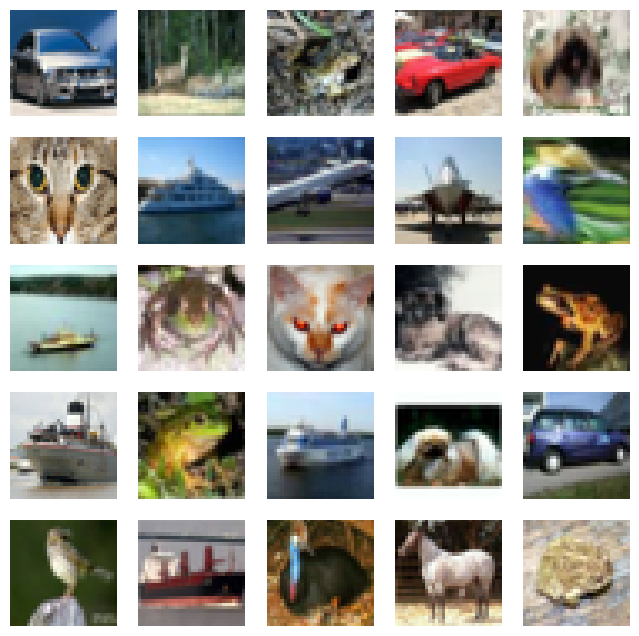

In [7]:
# Visualização das imagens

def visualize_mnist_images(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    #inputs = inputs.reshape(len(inputs), 1, 28, 28)
    #print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(False) # b = None
        # plot raw pixel data
        imagem = inputs[i]
        #xmax, xmin = imagem.max(), imagem.min()  # como esta normalização já foi feita no dataset, aqui não faz falta
        #imagem = (imagem - xmin)/(xmax - xmin)
        plt.imshow(imagem.permute((2, 1, 0)))
    # show the figure
    plt.show()

visualize_mnist_images(train_dl)

### Tarefa 6 (Verificar se o dataset está Balanceado)

-----------------------------------casos_treino-----------------------------------
casos: 40000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[3995 4004 3995 4003 3978 4002 4025 4002 3987 4009]
40000


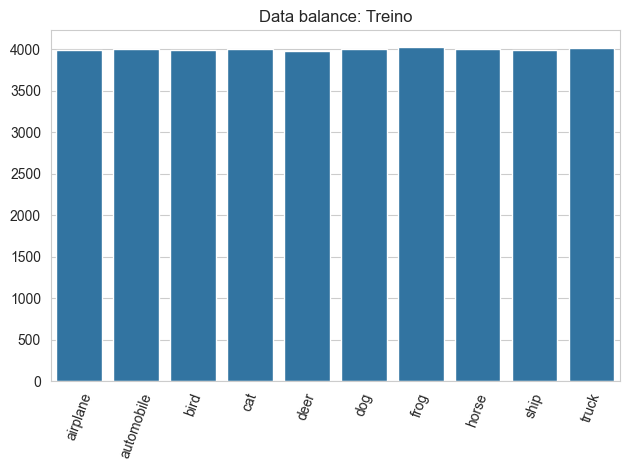

-----------------------------------casos_validação-----------------------------------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1005  996 1005  997 1022  998  975  998 1013  991]
10000


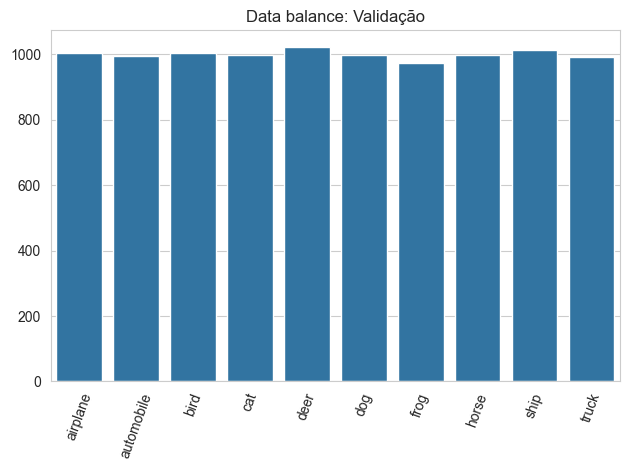

-----------------------------------casos_teste-----------------------------------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


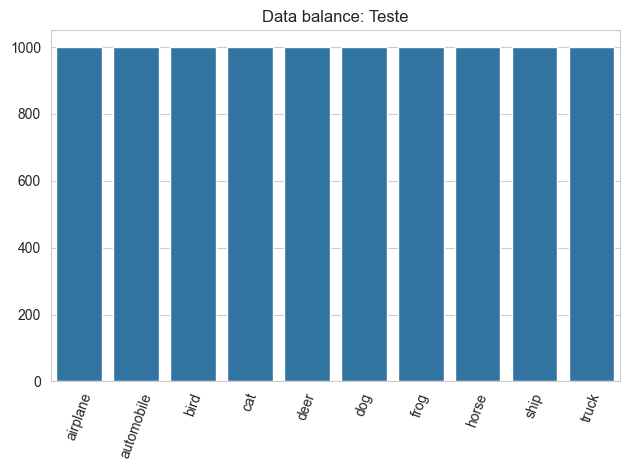

In [8]:
def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[list(dic_classes.keys())[n] for n in x]
    print([str(n)  for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x_ext,y= y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(train_dl_all, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(val_dl_all, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
visualize_holdout_balance(test_dl_all, 'Teste')

### Tarefa 7 (Modelos)

### Tarefa 7.1 (Modelo ResNet)

In [14]:
# ResidualBlock: ConvLayer1, BastchNorm1, ConvLayer2, BatchNorm2, Sequential)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(3, 3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(1, 1), stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # aqui junta a saída da convolução com o residual de trás
        out = nn.ReLU()(out)
        return out

# ResNet: blocos de Sequential
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        # Initial input conv
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3),stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Create blocks
        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)
    
    # A block is just two residual blocks for ResNet18
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
    # Output of one layer becomes input to the next
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
model = ResNet()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

### Tarefa 7.2 (CNN 1)

In [15]:
# CNN Model1: SequentialLayer1 (Conv, ReLU, MaxPool), SequentialLayer2 (Conv, ReLU, MaxPool), Linear, ReLu, Linear, Softmax
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=32*6*6 , out_features=100) # fully connected layer 5*5*32
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10) # output layer
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # flatten 
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out
  
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 32, 30, 30]         896
│    └─ReLU: 2-2                         [128, 32, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 32, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         9,248
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 100]                115,300
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tot

### Tarefa 7.3 (CNN 2)

In [16]:
# CNN Model2: Sequential1 (Conv, ReLU, MaxPool), Sequential2 (Conv, ReLU, MaxPool), Linear
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(in_features=32* 6* 6, out_features=10)  # Fully connected 1
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #Flatten
        out = self.fc1(out) #Dense
        return out
    
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 16, 30, 30]         448
│    └─ReLU: 2-2                         [128, 16, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 16, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         4,640
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 10]                 11,530
Total params: 16,618
Trainable params: 16,618
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 153.46
Input size (MB): 1.57
Forward/backward pass size (MB): 20.29
Params size (MB): 0.07
Estimated Total Size 

### Tarefa 7.4 (CNN 3)

In [17]:
# CNN Model3: Sequential1 (Conv, BatchNorm, ReLU, MaxPool), Sequential2 (Conv, BatchNorm, ReLU, MaxPool), Linear, Dropout, Linear, Linear
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64* 7* 7, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 64* 7* 7)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 14, 14]         128
│    └─ReLU: 2-7                         [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-8                    [128, 64, 7, 7]           --
├─Linear: 1-3                            [128, 600]                1,882,200
├─Dropout2d: 1-4                         [128, 600]                --
├─

c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


### Tarefa 7.4 (CNN 4)

In [18]:
# CNN Model4: Sequential (Conv, BatchNorm, ReLU, MaxPool, Dropout), Linear, Linear
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*14*14, out_features=128) # 16928
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(-1,32*14*14)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         2,432
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
│    └─Dropout2d: 2-5                    [128, 32, 14, 14]         --
├─Linear: 1-2                            [128, 128]                802,944
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 806,730
Trainable params: 806,730
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 347.01
Input size (MB): 1.57
Forward/backward pass size (MB): 51.52
Params size (MB): 3.23
Estimated Total Size (MB): 56.32


### Tarefa 8 (Treinar os Modelos)

In [10]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer, EPOCHS=10):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {} # para o livelossplot
        # Train phase
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        # Validation phase
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()   
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file) # para gravar o modelo no final do treino

### Tarefa 8.1 (Treinar ResNet)

In [59]:
model = ResNet()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

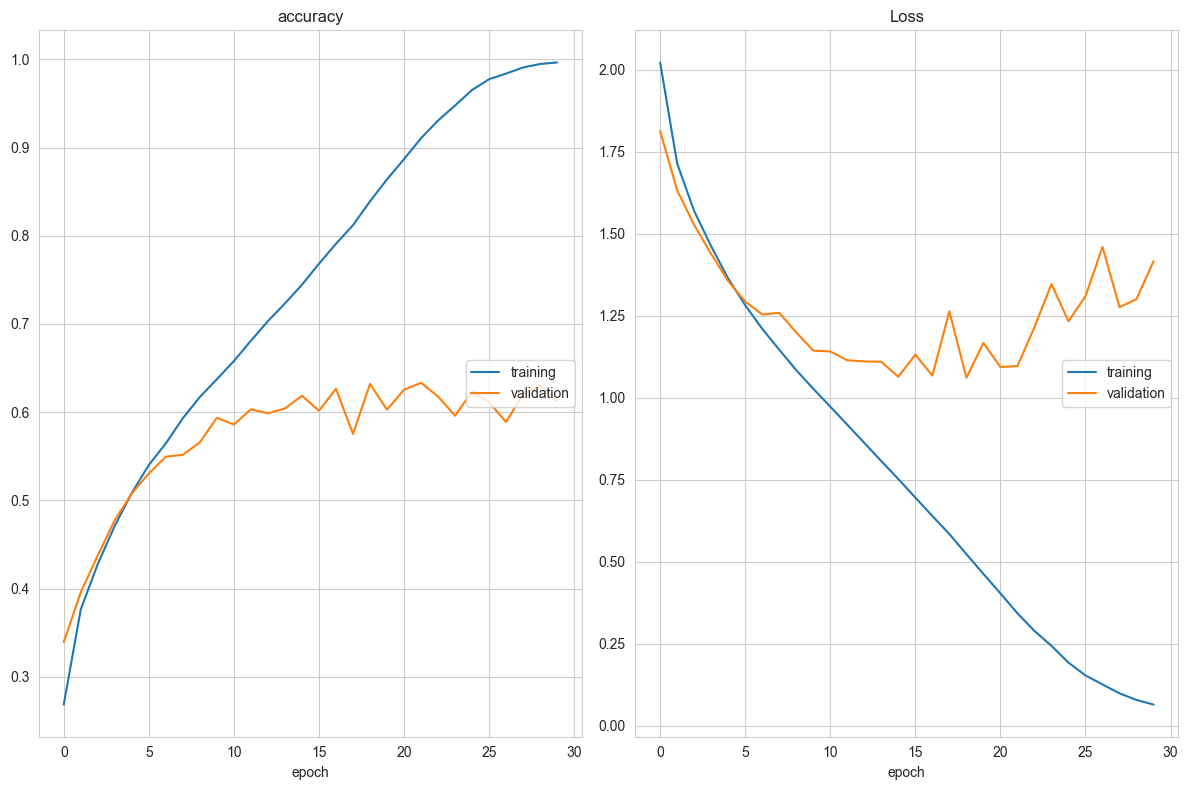

accuracy
	training         	 (min:    0.269, max:    0.996, cur:    0.996)
	validation       	 (min:    0.339, max:    0.633, cur:    0.613)
Loss
	training         	 (min:    0.064, max:    2.023, cur:    0.064)
	validation       	 (min:    1.061, max:    1.814, cur:    1.417)
Tempo gasto: 1241.8376849000015 segundos


In [60]:
epochs = 30
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 


starttime = time.perf_counter()
train_model('./CNNModel_cifar_Resnet.pth', train_dl, val_dl, model, criterion, optimizer, epochs)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### Tarefa 8.2 (Treinar CNN 1)

In [11]:
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 32, 30, 30]         896
│    └─ReLU: 2-2                         [128, 32, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 32, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         9,248
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 100]                115,300
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tot

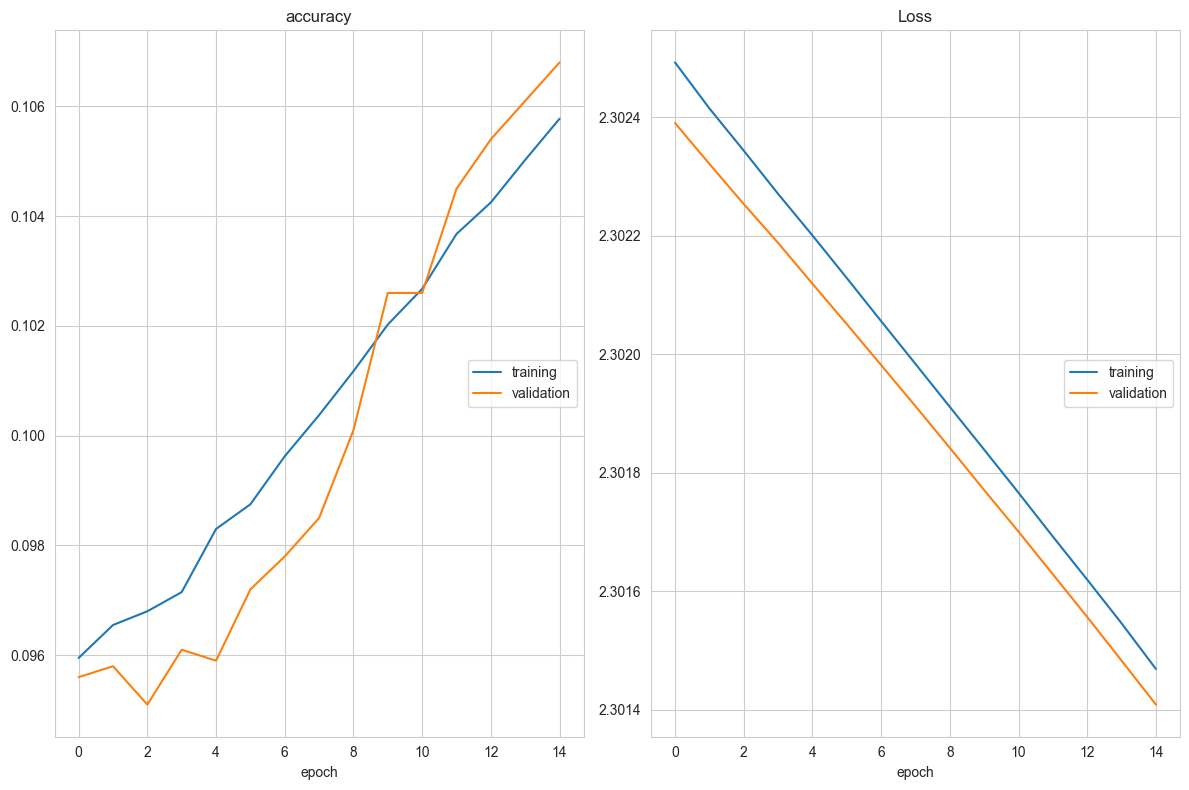

accuracy
	training         	 (min:    0.096, max:    0.106, cur:    0.106)
	validation       	 (min:    0.095, max:    0.107, cur:    0.107)
Loss
	training         	 (min:    2.301, max:    2.302, cur:    2.301)
	validation       	 (min:    2.301, max:    2.302, cur:    2.301)
Tempo gasto: 363.74670380000316 segundos


In [12]:
epochs = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 

starttime = time.perf_counter()
train_model('./CNNModel_cifar_1.pth', train_dl, val_dl, model, criterion, optimizer, epochs)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### Tarefa 8.3 (Treinar CNN 2)

In [63]:
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 16, 30, 30]         448
│    └─ReLU: 2-2                         [128, 16, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 16, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         4,640
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 10]                 11,530
Total params: 16,618
Trainable params: 16,618
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 153.46
Input size (MB): 1.57
Forward/backward pass size (MB): 20.29
Params size (MB): 0.07
Estimated Total Size 

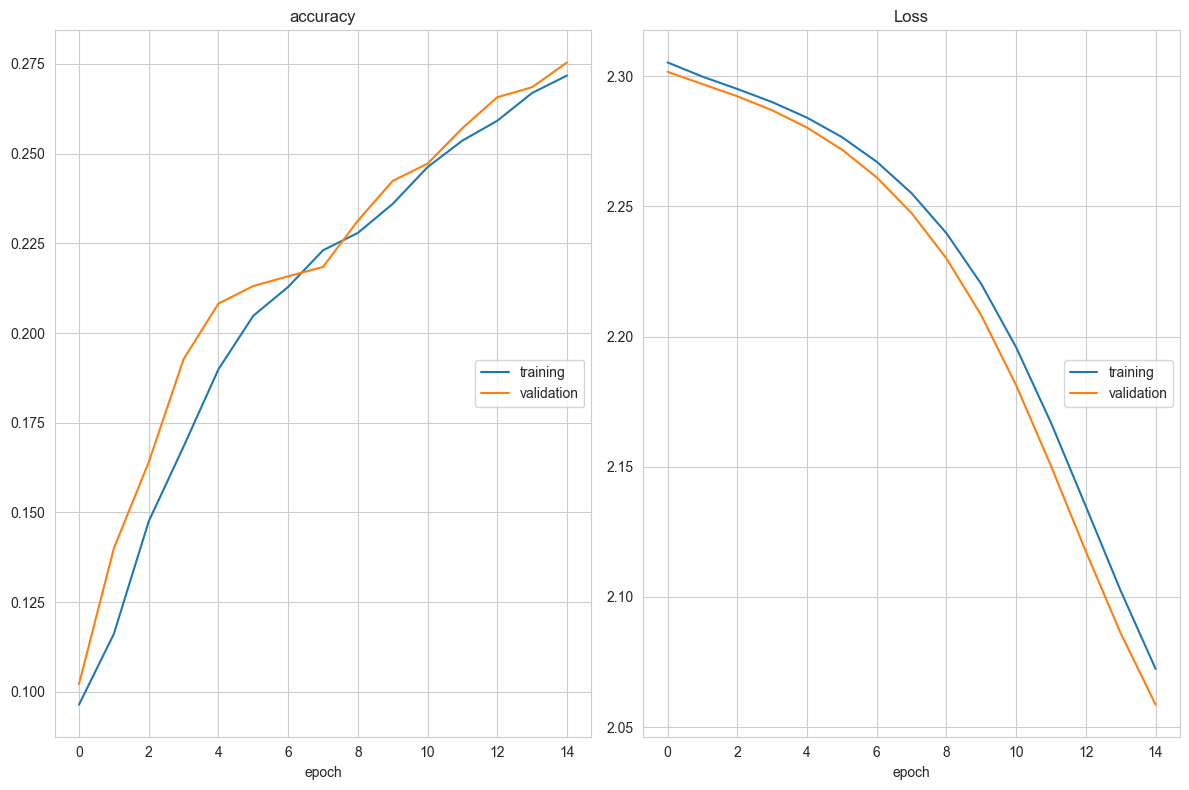

accuracy
	training         	 (min:    0.096, max:    0.272, cur:    0.272)
	validation       	 (min:    0.102, max:    0.275, cur:    0.275)
Loss
	training         	 (min:    2.072, max:    2.305, cur:    2.072)
	validation       	 (min:    2.059, max:    2.302, cur:    2.059)
Tempo gasto: 369.69045090000145 segundos


In [64]:
epochs = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 

starttime = time.perf_counter()
train_model('./CNNModel_cifar_2.pth', train_dl, val_dl, model, criterion, optimizer, epochs)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### Tarefa 8.4 (Treinar CNN 3)

In [65]:
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 14, 14]         128
│    └─ReLU: 2-7                         [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-8                    [128, 64, 7, 7]           --
├─Linear: 1-3                            [128, 600]                1,882,200
├─Dropout2d: 1-4                         [128, 600]                --
├─

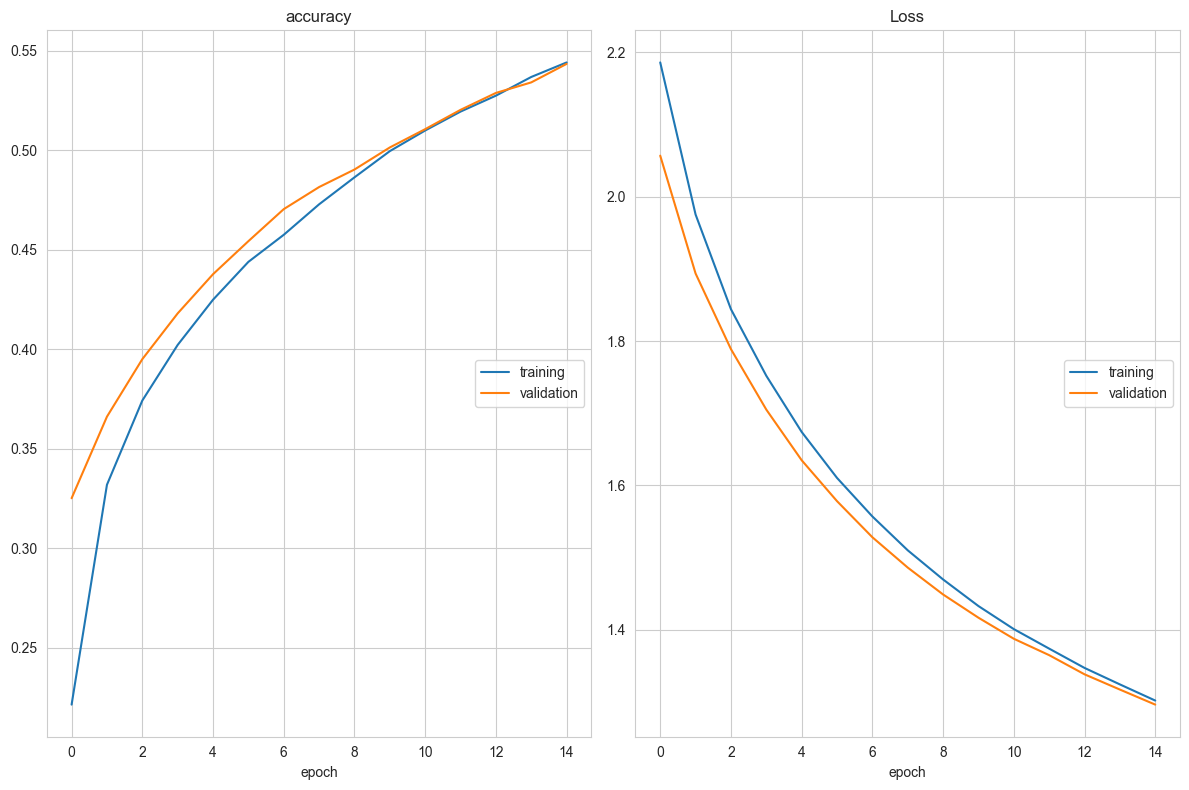

accuracy
	training         	 (min:    0.221, max:    0.544, cur:    0.544)
	validation       	 (min:    0.325, max:    0.543, cur:    0.543)
Loss
	training         	 (min:    1.302, max:    2.186, cur:    1.302)
	validation       	 (min:    1.297, max:    2.057, cur:    1.297)
Tempo gasto: 369.2832156000004 segundos


In [66]:
epochs = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 

starttime = time.perf_counter()
train_model('./CNNModel_cifar_3.pth', train_dl, val_dl, model, criterion, optimizer, epochs)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### Tarefa 8.5 (Treinar CNN 4)

In [67]:
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         2,432
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
│    └─Dropout2d: 2-5                    [128, 32, 14, 14]         --
├─Linear: 1-2                            [128, 128]                802,944
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 806,730
Trainable params: 806,730
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 347.01
Input size (MB): 1.57
Forward/backward pass size (MB): 51.52
Params size (MB): 3.23
Estimated Total Size (MB): 56.32


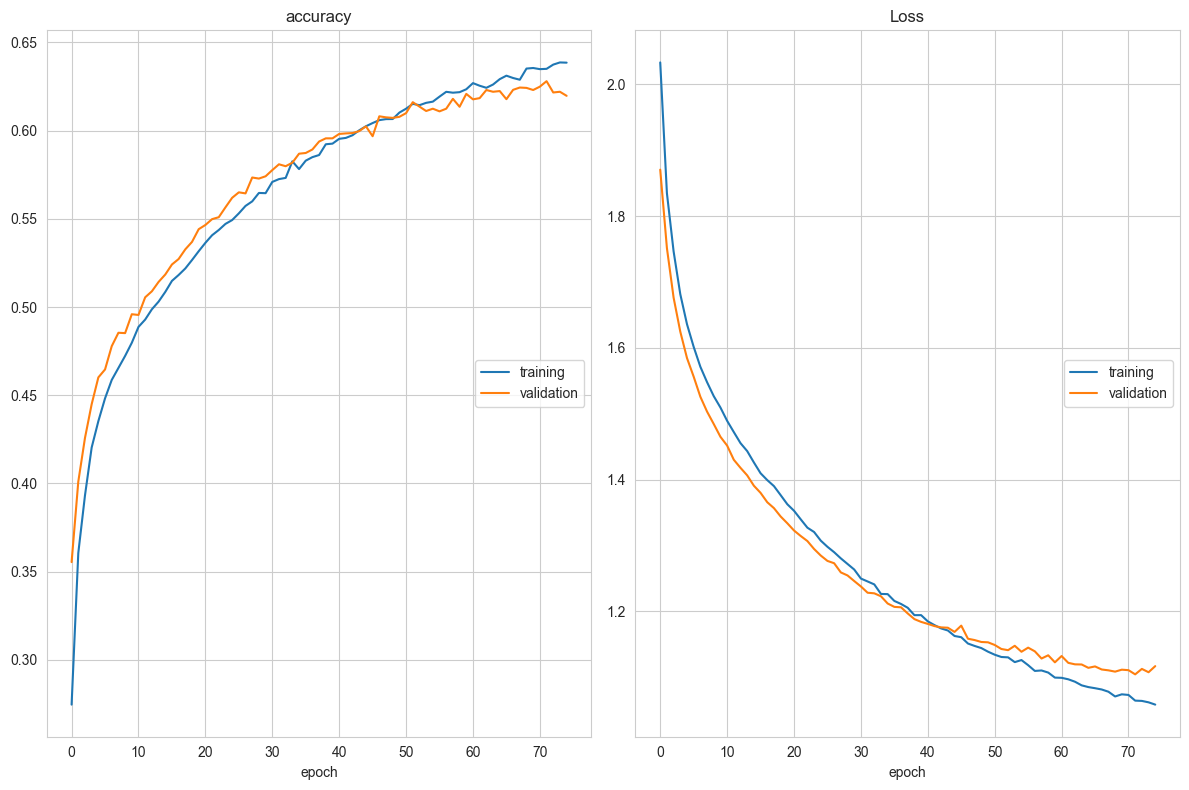

accuracy
	training         	 (min:    0.275, max:    0.639, cur:    0.638)
	validation       	 (min:    0.355, max:    0.628, cur:    0.620)
Loss
	training         	 (min:    1.058, max:    2.033, cur:    1.058)
	validation       	 (min:    1.104, max:    1.871, cur:    1.117)
Tempo gasto: 1844.182689899997 segundos


In [68]:
epochs = 75
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 

starttime = time.perf_counter()
train_model('./CNNModel_cifar_4.pth', train_dl, val_dl, model, criterion, optimizer, epochs)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### Tarefa 9 (Avaliar Modelos)

In [20]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [21]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        # avaliar o modelo com os casos de teste
        inputs = inputs.to(cuda)
        labels = labels.to(cuda)
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        # converter para a class dos labels
        yprev = np.argmax(yprev, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
    # calcular a accuracy
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

 
def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    

### Tarefa 9.1 (Avaliar ResNet)

real:[0] previsão:[0]
real:[3] previsão:[3]
real:[7] previsão:[2]
real:[5] previsão:[5]
real:[9] previsão:[9]
real:[6] previsão:[6]
real:[4] previsão:[3]
real:[4] previsão:[3]
real:[9] previsão:[9]
real:[0] previsão:[0]
real:[5] previsão:[3]
real:[6] previsão:[6]
real:[6] previsão:[6]
real:[8] previsão:[8]
real:[3] previsão:[7]
real:[5] previsão:[5]
real:[6] previsão:[0]
real:[2] previsão:[2]
real:[3] previsão:[5]
real:[3] previsão:[3]
Accuracy: 0.578

acertou:74 falhou:54
Accuracy: 0.578

acertou:74 falhou:54
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       1.00      0.75      0.86         8
           2       0.54      0.44      0.48        16
           3       0.37      0.37      0.37        19
           4       0.25      0.14      0.18         7
           5       0.45      0.53      0.49        17
           6       0.67      0.80      0.73        15
           7       0.67      0.20      0.31        

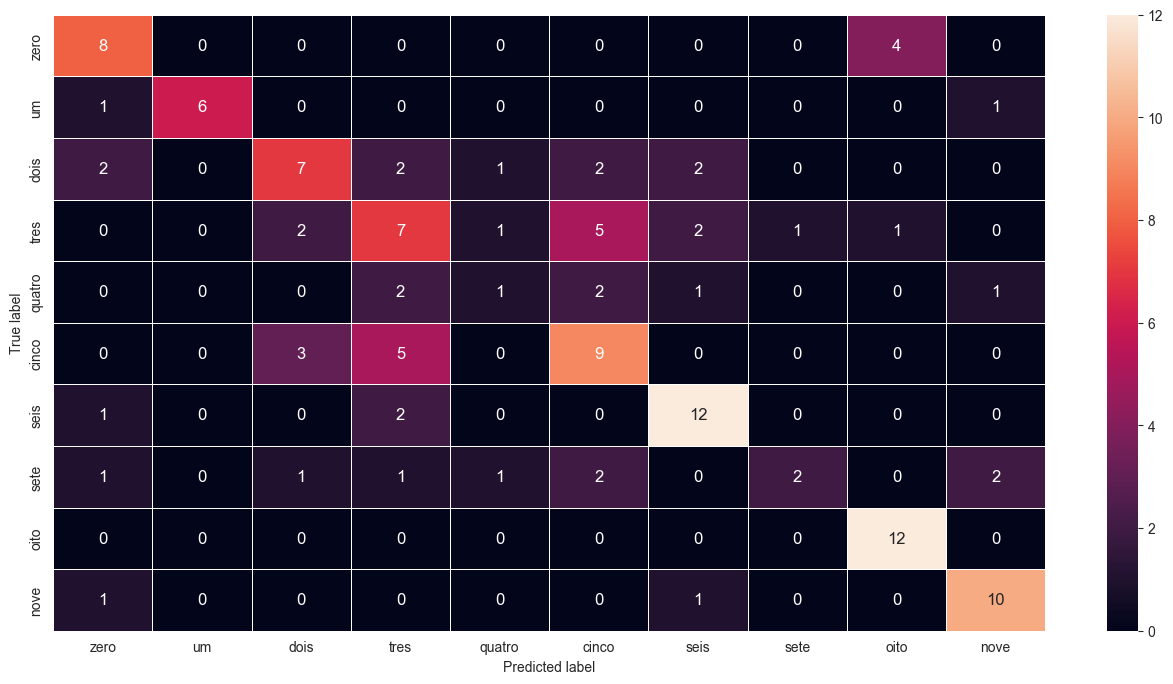

In [23]:
with safe_globals([ResNet, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_Resnet.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
    
actual_values, predictions = evaluate_model(final_test_dll_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

### Tarefa 9.2 (Avaliar CNN 1)

real:[6] previsão:[0]
real:[5] previsão:[0]
real:[4] previsão:[0]
real:[8] previsão:[0]
real:[2] previsão:[0]
real:[3] previsão:[0]
real:[8] previsão:[9]
real:[9] previsão:[9]
real:[2] previsão:[9]
real:[6] previsão:[0]
real:[5] previsão:[0]
real:[5] previsão:[0]
real:[9] previsão:[0]
real:[5] previsão:[0]
real:[9] previsão:[9]
real:[9] previsão:[0]
real:[9] previsão:[0]
real:[1] previsão:[9]
real:[5] previsão:[0]
real:[0] previsão:[0]
Accuracy: 0.086

acertou:11 falhou:117
Accuracy: 0.086

acertou:11 falhou:117
              precision    recall  f1-score   support

           0       0.08      0.67      0.14        12
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00      

c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

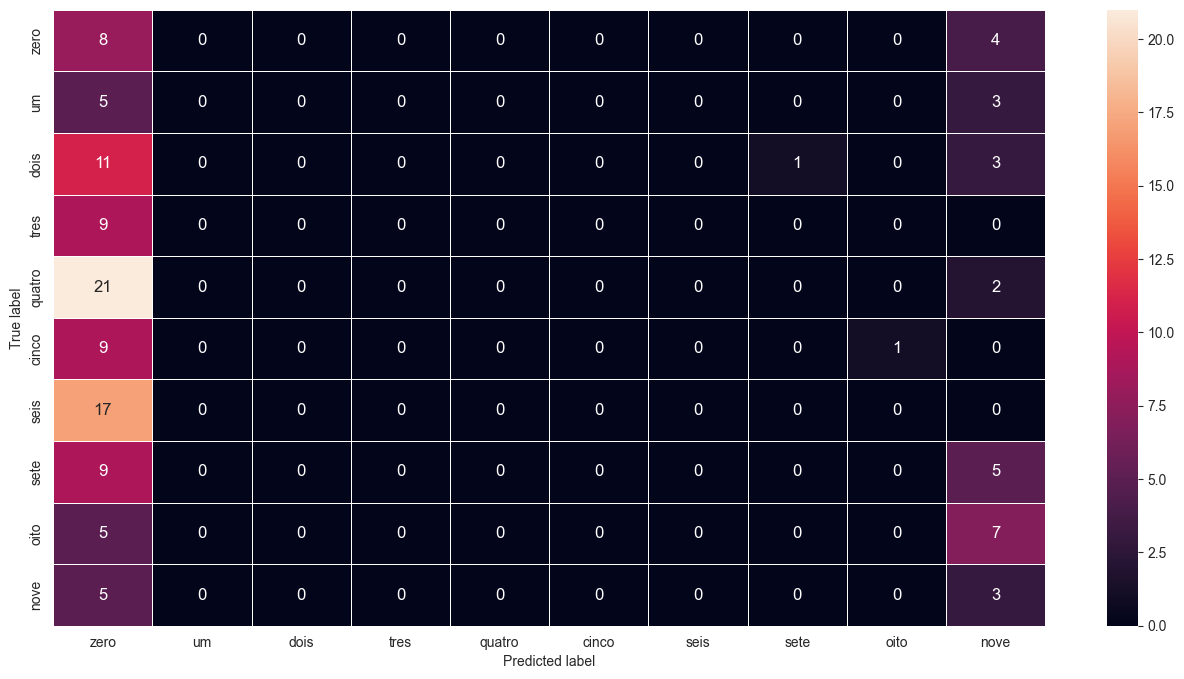

In [25]:
with safe_globals([CNNModel_1, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_1.pth')
actual_values, predictions = evaluate_model(final_test_dll_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

### Tarefa 9.3 (Avaliar CNN 2)

real:[2] previsão:[6]
real:[0] previsão:[0]
real:[6] previsão:[6]
real:[1] previsão:[6]
real:[1] previsão:[8]
real:[0] previsão:[0]
real:[9] previsão:[5]
real:[6] previsão:[6]
real:[1] previsão:[6]
real:[7] previsão:[7]
real:[3] previsão:[6]
real:[9] previsão:[1]
real:[2] previsão:[0]
real:[8] previsão:[6]
real:[4] previsão:[0]
real:[5] previsão:[5]
real:[4] previsão:[6]
real:[4] previsão:[6]
real:[3] previsão:[5]
real:[1] previsão:[8]
Accuracy: 0.258

acertou:33 falhou:95
Accuracy: 0.258

acertou:33 falhou:95
              precision    recall  f1-score   support

           0       0.47      0.75      0.58        12
           1       0.33      0.06      0.11        16
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        15
           5       0.06      0.14      0.09         7
           6       0.21      0.73      0.32        11
           7       0.14      0.07      0.10        

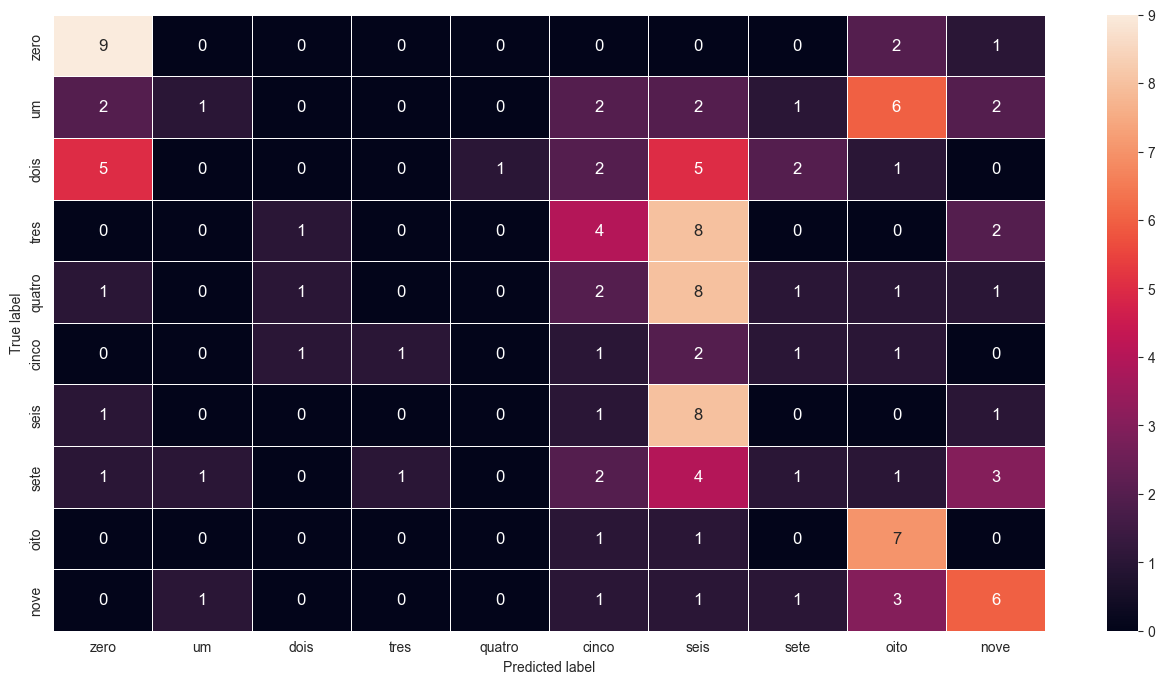

In [26]:
with safe_globals([CNNModel_2, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_2.pth')
actual_values, predictions = evaluate_model(final_test_dll_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

### Tarefa 9.4 (Avaliar CNN 3)

c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


real:[3] previsão:[3]
real:[5] previsão:[6]
real:[7] previsão:[5]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[0] previsão:[8]
real:[9] previsão:[6]
real:[3] previsão:[3]
real:[8] previsão:[8]
real:[0] previsão:[0]
real:[9] previsão:[9]
real:[9] previsão:[9]
real:[8] previsão:[8]
real:[0] previsão:[0]
real:[1] previsão:[0]
real:[1] previsão:[3]
real:[2] previsão:[3]
real:[0] previsão:[8]
real:[8] previsão:[8]
real:[5] previsão:[5]
Accuracy: 0.570

acertou:73 falhou:55
Accuracy: 0.570

acertou:73 falhou:55
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.69      0.60      0.64        15
           2       0.43      0.50      0.46        12
           3       0.43      0.43      0.43        14
           4       0.62      0.45      0.53        11
           5       0.47      0.54      0.50        13
           6       0.53      0.62      0.57        13
           7       0.50      0.55      0.52        

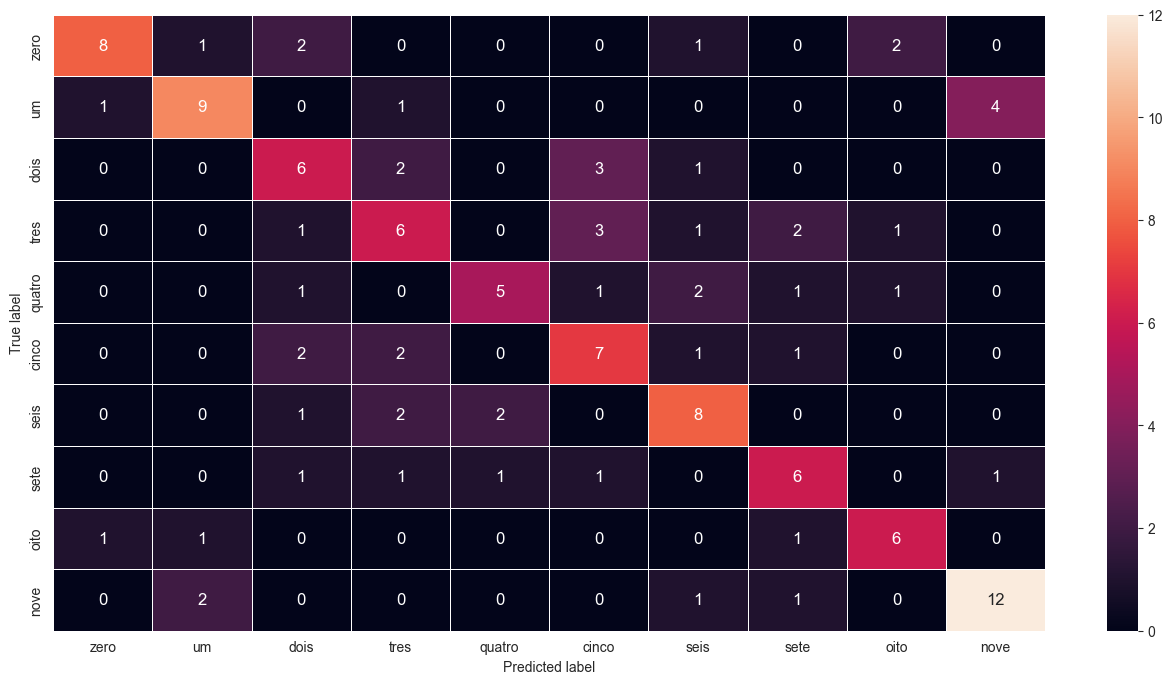

In [27]:
with safe_globals([CNNModel_3, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_3.pth')
actual_values, predictions = evaluate_model(final_test_dll_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

### Tarefa 9.5 (Avaliar CNN 4)

real:[7] previsão:[6]
real:[7] previsão:[7]
real:[4] previsão:[3]
real:[7] previsão:[7]
real:[7] previsão:[7]
real:[8] previsão:[8]
real:[3] previsão:[3]
real:[3] previsão:[3]
real:[7] previsão:[7]
real:[4] previsão:[2]
real:[7] previsão:[4]
real:[3] previsão:[5]
real:[0] previsão:[0]
real:[2] previsão:[6]
real:[3] previsão:[4]
real:[5] previsão:[5]
real:[5] previsão:[5]
real:[5] previsão:[3]
real:[0] previsão:[0]
real:[7] previsão:[4]
Accuracy: 0.609

acertou:78 falhou:50
Accuracy: 0.609

acertou:78 falhou:50
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.73      0.65      0.69        17
           2       0.70      0.47      0.56        15
           3       0.60      0.64      0.62        14
           4       0.50      0.38      0.43        13
           5       0.43      0.43      0.43         7
           6       0.42      0.89      0.57         9
           7       0.80      0.67      0.73        

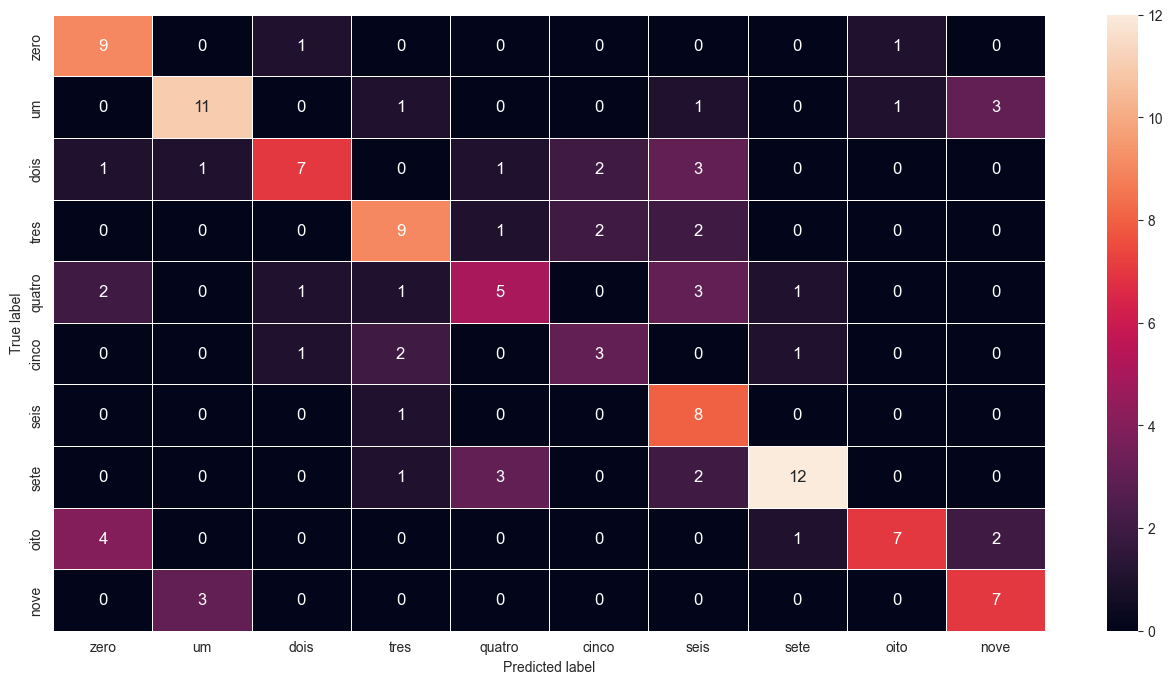

In [29]:
with safe_globals([CNNModel_4, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_4.pth')
actual_values, predictions = evaluate_model(final_test_dll_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

### Tarefa 10 (Usar os Modelos)

In [32]:
def make_prediction(model, img): # img shape (784,1)
    img = img.reshape(1, 3, 32, 32) 
    print(img.shape)
    print(img.dtype) 
    img = img.to(device)
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    x_ext=list(dic_classes.keys())
    print(f"predict:{prediction} - {x_ext[prediction]}")
    img=img.cpu()
    plt.axis('off')
    plt.grid(False)
    plt.imshow(img[0].permute((2, 1, 0)))
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Tarefa 10.1 (Usar ResNet)

torch.Size([1, 3, 32, 32])
torch.float32
predict:2 - bird


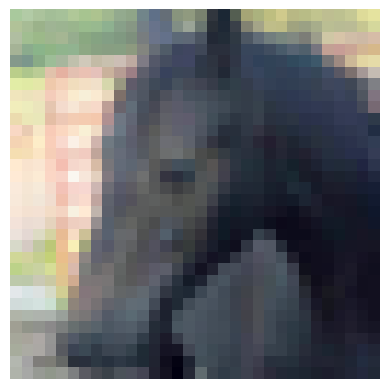

In [33]:
with safe_globals([ResNet, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_Resnet.pth')

imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) 

### Tarefa 10.2 (Usar CNN 1)

torch.Size([1, 3, 32, 32])
torch.float32
predict:0 - airplane


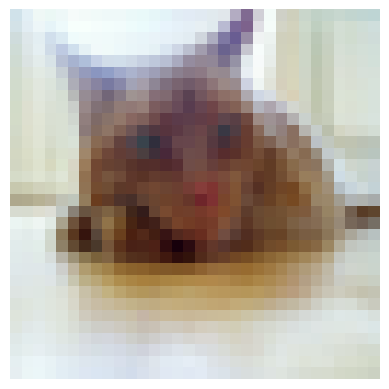

In [35]:
with safe_globals([CNNModel_1, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_1.pth')

imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) 

### Tarefa 10.3 (Usar CNN 2)

torch.Size([1, 3, 32, 32])
torch.float32
predict:7 - horse


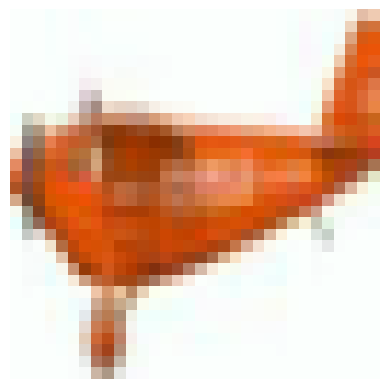

In [36]:
with safe_globals([CNNModel_2, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_2.pth')

imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) 

### Tarefa 10.4 (Usar CNN 3)

torch.Size([1, 3, 32, 32])
torch.float32
predict:3 - cat


c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


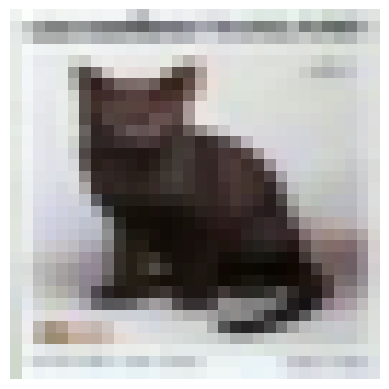

In [37]:
with safe_globals([CNNModel_3, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_3.pth')

imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) 

### Tarefa 10.5 (Usar CNN 4)

torch.Size([1, 3, 32, 32])
torch.float32
predict:9 - truck


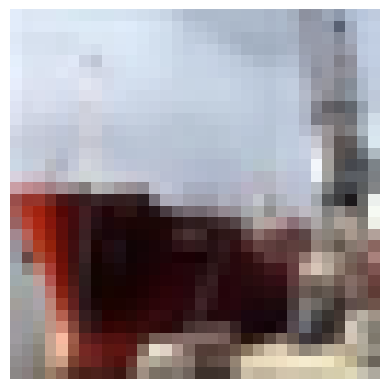

: 

In [ ]:
with safe_globals([CNNModel_4, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss, ResidualBlock, nn.AvgPool2d, nn.Dropout2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d, nn.CrossEntropyLoss, nn.Module, Sequential, Module, Linear, Softmax, CrossEntropyLoss]):
    model= torch.load('./CNNModel_cifar_4.pth')

imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) 